In [1]:
import sys, os
import pandas as pd
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning,
    module="sklearn",
)

from sklearn import metrics
from scipy import stats
from flaml import AutoML # https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML/

import torch
torch.manual_seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### Loading and wrangling the data

In [2]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_2.csv").drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq",
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id,binder_id,seq_len_binder,seq_len_target,pdb_len_binder,pdb_len_target
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,40,138,40,138
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,62,101,62,101
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,61,101,61,101
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,64,101,64,101
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,64,101,64,101
...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,55,165,55,165
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,56,165,56,165
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,56,165,56,165
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,57,165,57,165


In [3]:
meta_binders_encodings_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_binders"
meta_binders_files = sorted(os.listdir(meta_binders_encodings_path))  # keep files & embeddings aligned
meta_binders = [file.split(".")[0] for file in meta_binders_files]
meta_binders_embedings = [np.load(os.path.join(meta_binders_encodings_path, f))[0] for f in meta_binders_files]

meta_targets_embedings_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_targets"
meta_targets_files = sorted(os.listdir(meta_targets_embedings_path))  # keep files & embeddings aligned
meta_targets = [file.split(".")[0] for file in meta_targets_files]
meta_targets_embedings = [np.load(os.path.join(meta_targets_embedings_path, f))[0] for f in meta_targets_files]

In [4]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"],
]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

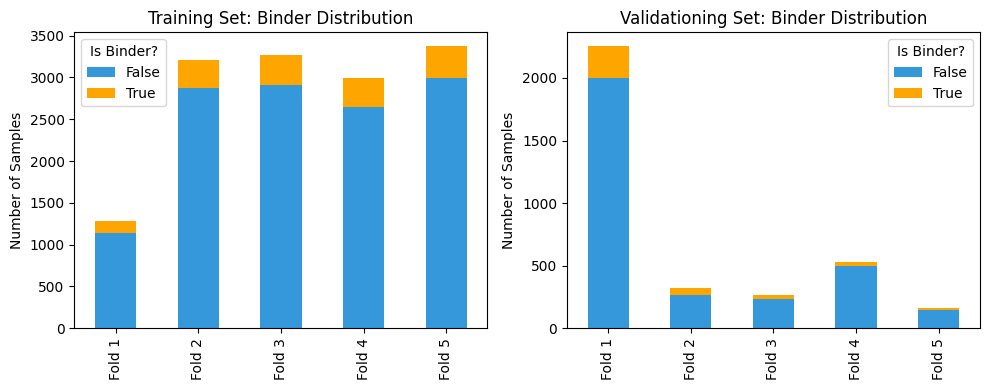

In [5]:
# 1. Define your splits (as provided)
cv_splits = [
    (cv_splits[0][0], cv_splits[0][1]),
    (cv_splits[1][0], cv_splits[1][1]),
    (cv_splits[2][0], cv_splits[2][1]),
    (cv_splits[3][0], cv_splits[3][1]),
    (cv_splits[4][0], cv_splits[4][1])
]

# 2. Extract counts for each fold
plot_data = []
for i, (val_targets, train_targets) in enumerate(cv_splits):
    for set_type, targets_in_set in [('Train', train_targets), ('Validation', val_targets)]:
        # Filter the df for targets in this set
        subset = interaction_df[interaction_df['target_id'].isin(targets_in_set)]
        counts = subset['binder'].value_counts()
        
        plot_data.append({
            'Fold': f'Fold {i+1}', 
            'Set': set_type, 
            'Binder': 'True', 
            'Count': counts.get(True, 0)
        })
        plot_data.append({
            'Fold': f'Fold {i+1}', 
            'Set': set_type, 
            'Binder': 'False', 
            'Count': counts.get(False, 0)
        })

# 3. Create the Visualization
plot_df = pd.DataFrame(plot_data)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

for ax, st in zip(axes, ['Train', 'Validation']):
    subset = plot_df[plot_df['Set'] == st]
    # Pivot to create a stacked bar chart (Binder vs Fold)
    pivot_df = subset.pivot(index='Fold', columns='Binder', values='Count')
    pivot_df.plot(kind='bar', stacked=True, ax=ax, color=['#3498db', 'orange'])
    
    ax.set_title(f'{st}ing Set: Binder Distribution', fontsize=12)
    ax.set_ylabel('Number of Samples')
    ax.set_xlabel('')
    ax.legend(title='Is Binder?')

plt.tight_layout()
plt.show()

In [6]:
# binder_id : target_id
binder_target_Dict = dict(zip(interaction_df.binder_id, interaction_df.target_id))

# binder_id : label
binder_lbl = dict(zip(interaction_df.binder_id, interaction_df.binder))

# assigning index/number to target (for later)
target_idx = {target: idx for idx, target in enumerate(meta_targets)}

# all binders (list) but id is target id
targets_per_binder = [binder_target_Dict[b] for b in meta_binders]

# all binders (list) but id is target number
groups_all = np.array([target_idx[t] for t in targets_per_binder])

# existing features/labels aligned to meta_binders
binders_emb = [b.mean(axis=0) for b in meta_binders_embedings]
targets_emb = [meta_targets_embedings[target_idx[t]].mean(axis=0) for t in targets_per_binder]
labels = [binder_lbl[b] for b in meta_binders]

- mean pooling so that all sequence embeddings are represented by single vector dimenssion (1152, )
- `np.concatenate([smth1, smth2], axis=0).shape --> (2304,)`
- stack all the concatenated entries

In [7]:
smth1 = binders_emb[1]
smth2 = targets_emb[1]
np.concatenate([smth1, smth2], axis=0).shape

def build_Xy(binders, targets, labels_):
    # np.concatenate([binders[i], targets[i]], axis=0).shape --> (2304,)
    X = np.stack([np.concatenate([binders[i], targets[i]], axis=0) for i in range(len(binders))], axis=0)
    y = np.array(labels_)
    return X, y

In [8]:
CV_Folds = {}

for idx, (val_t, train_t) in enumerate(cv_splits):
    # masks based on target IDs aligned to meta_binders
    mask_val = [t in val_t for t in targets_per_binder]
    mask_train = [t in train_t for t in targets_per_binder]

    # split features/labels
    val_binders = list(compress(binders_emb, mask_val))
    val_targets = list(compress(targets_emb, mask_val))
    val_labels = list(compress(labels, mask_val))

    train_binders = list(compress(binders_emb, mask_train))
    train_targets = list(compress(targets_emb, mask_train))
    train_labels = list(compress(labels, mask_train))

    # build arrays
    train_X, train_y = build_Xy(train_binders, train_targets, train_labels)
    val_X, val_y = build_Xy(val_binders, val_targets, val_labels)

    # groups (for later use in FLAML)
    groups_train = np.array(list(compress(groups_all, mask_train)))
    # groups_val   = np.array(list(compress(groups_all, mask_val)))

    CV_Folds[idx] = {
        "X_train": (train_X, train_y),
        "X_val":   (val_X,   val_y),
        "groups_train": groups_train
    }

In [9]:
assert len(CV_Folds[4]["groups_train"]) == len(CV_Folds[4]["X_train"][0])
print(len(CV_Folds[4]["X_train"][0]))
print(len(CV_Folds[4]["groups_train"]))

3371
3371


In [10]:
CV_Folds[0]["X_train"]

(array([[-0.0133109 , -0.01012459, -0.03152361, ..., -0.01039064,
          0.0029597 , -0.00737904],
        [-0.01929154, -0.01737176, -0.02785511, ..., -0.01039064,
          0.0029597 , -0.00737904],
        [-0.00376214, -0.00062757, -0.00784948, ..., -0.01039064,
          0.0029597 , -0.00737904],
        ...,
        [-0.00662503, -0.00645584, -0.01993365, ..., -0.00385113,
          0.00849067, -0.0060798 ],
        [-0.009697  ,  0.00665899, -0.01474744, ..., -0.00385113,
          0.00849067, -0.0060798 ],
        [-0.00272596, -0.00046762, -0.01311125, ..., -0.00385113,
          0.00849067, -0.0060798 ]], dtype=float32),
 array([False, False, False, ...,  True,  True,  True]))

### AutoML "classification" was run optimizing on metirc "ap" (600 seconds)

In [36]:
# Start the total timer for the entire CV process
total_start_time = time.time()

CV_BestModels600 = {}

for i in tqdm(range(len(CV_Folds)), desc="Outer CV folds"):
    # Record the start time of this specific fold
    fold_start_time = time.time()

    # unpack
    X_train, y_train = CV_Folds[i]["X_train"]
    X_val,   y_val   = CV_Folds[i]["X_val"]
    groups_train     = CV_Folds[i]["groups_train"]

    automl = AutoML()
    settings = {
        "time_budget": 600,
        "task": "classification",
        "metric": "ap",
        "verbose": 1,
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
        "groups": groups_train,
    }
    
    # Run FLAML
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    # Calculate metrics (predict, proba, etc.)
    y_pred = automl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    classes_ = getattr(automl, "classes_", np.unique(y_train))
    if hasattr(automl, "predict_proba"):
        y_proba = automl.predict_proba(X_val)
        pos_label = 1 if 1 in classes_ else classes_[-1]
        pos_idx = list(classes_).index(pos_label)
        y_score = y_proba[:, pos_idx]
    else:
        pos_label = 1 if 1 in classes_ else classes_[-1]
        y_score = (y_pred == pos_label).astype(float)

    ap = average_precision_score(y_val, y_score)
    auroc = roc_auc_score(y_val, y_score)

    # Calculate fold duration
    fold_duration = time.time() - fold_start_time

    CV_BestModels600[i] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "loss": automl.best_loss,
        "accuracy": acc,
        "ap": ap,
        "auroc": auroc,
        "duration_sec": fold_duration # Store the time taken
    }
    
    print(f"  > Fold {i} finished in {fold_duration:.2f} seconds.")

# Final report
total_duration = time.time() - total_start_time
print(f"\n--- Total Cross-Validation Time: {total_duration/60:.2f} minutes ---")

Outer CV folds:  20%|█████████████▌                                                      | 1/5 [10:09<40:39, 609.98s/it]

  > Fold 0 finished in 609.98 seconds.


Outer CV folds:  40%|███████████████████████████▏                                        | 2/5 [20:23<30:36, 612.10s/it]

  > Fold 1 finished in 613.58 seconds.


Outer CV folds:  60%|████████████████████████████████████████▊                           | 3/5 [30:28<20:17, 608.73s/it]

  > Fold 2 finished in 604.71 seconds.


Outer CV folds:  80%|██████████████████████████████████████████████████████▍             | 4/5 [40:33<10:07, 607.21s/it]

  > Fold 3 finished in 604.88 seconds.


Outer CV folds: 100%|████████████████████████████████████████████████████████████████████| 5/5 [50:57<00:00, 611.42s/it]

  > Fold 4 finished in 623.96 seconds.

--- Total Cross-Validation Time: 50.95 minutes ---


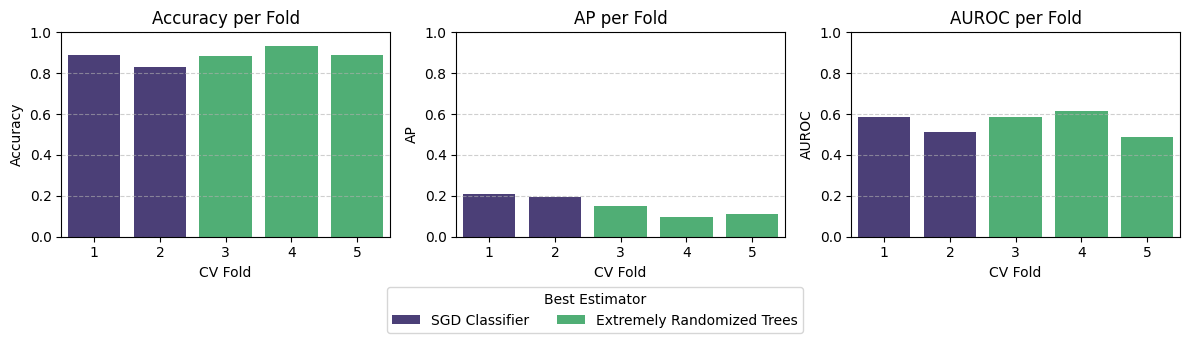

In [66]:
Df600sec = pd.DataFrame({
    'CV Fold': [1, 2, 3, 4, 5],
    'Estimator': ["SGD Classifier", "SGD Classifier", "Extremely Randomized Trees", "Extremely Randomized Trees", "Extremely Randomized Trees"],
    'Accuracy': [0.889, 0.831, 0.884, 0.931, 0.888],
    'AP': [0.21, 0.195, 0.149, 0.097, 0.11],
    'AUROC': [0.587, 0.512, 0.585, 0.613, 0.488]
})

# Setup for subplots
metrics = ['Accuracy', 'AP', 'AUROC']
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
palette = sns.color_palette("viridis", 25)
color_map = {
    "SGD Classifier": palette[3],
    "Extremely Randomized Trees": palette[17],
    "XGBoost": palette[24]
}

for i, metric in enumerate(metrics):
    sns.barplot(data=Df600sec, x='CV Fold', y=metric, hue='Estimator', palette=color_map, ax=axes[i], dodge=False)
    axes[i].set_title(f'{metric} per Fold')
    axes[i].set_ylim(0, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].get_legend().remove() # Hide individual legends

# Single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Best Estimator (FLAML for 600 each CV-fold)', loc='lower center',
fig.legend(handles, labels, title='Best Estimator', loc='lower center', 
           bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.savefig('fold_performance.png', bbox_inches='tight')

In [25]:
# # Data Preparation
# Df500sec = pd.DataFrame({
#     'CV Fold': [1, 2, 3, 4, 5],
#     'Estimator': ["Extremely Randomized Trees", "SGD Classifier", "XGBoost", "XGBoost", "Extremely Randomized Trees"],
#     'Accuracy': [0.105, 0.831, 0.884, 0.931, 0.888],
#     'AP': [0.095, 0.187, 0.106, 0.103, 0.101],
#     'AUROC': [0.401, 0.501, 0.453, 0.479, 0.441]
# })

# # Setup for subplots
# metrics = ['Accuracy', 'AP', 'AUROC']
# fig, axes = plt.subplots(1, 3, figsize=(12, 3))
# palette = sns.color_palette("viridis", n_colors=len(Df500sec['Estimator'].unique()))

# for i, metric in enumerate(metrics):
#     sns.barplot(
#         data=Df500sec, x='CV Fold', y=metric, hue='Estimator', 
#         palette=palette, ax=axes[i], dodge=False
#     )
#     axes[i].set_title(f'{metric} per Fold')
#     axes[i].set_ylim(0, 1.0)
#     axes[i].grid(axis='y', linestyle='--', alpha=0.6)
#     axes[i].get_legend().remove() # Hide individual legends

# # Single legend for the entire figure
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Estimator', loc='lower center', 
#            bbox_to_anchor=(0.5, -0.15), ncol=3)

# plt.tight_layout()
# plt.savefig('fold_performance.png', bbox_inches='tight')

### AutoML "classification" was run optimizing on metirc "ap" (900 seconds)

In [11]:
# Start the total timer for the entire CV process
total_start_time = time.time()

CV_BestModels900 = {}

for i in tqdm(range(len(CV_Folds)), desc="Outer CV folds"):
    # Record the start time of this specific fold
    fold_start_time = time.time()

    # unpack
    X_train, y_train = CV_Folds[i]["X_train"]
    X_val,   y_val   = CV_Folds[i]["X_val"]
    groups_train     = CV_Folds[i]["groups_train"]

    automl = AutoML()
    settings = {
        "time_budget": 900,
        "task": "classification",
        "metric": "ap",
        "verbose": 1,
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
        "groups": groups_train,
    }
    
    # Run FLAML
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    # Calculate metrics (predict, proba, etc.)
    y_pred = automl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    classes_ = getattr(automl, "classes_", np.unique(y_train))
    if hasattr(automl, "predict_proba"):
        y_proba = automl.predict_proba(X_val)
        pos_label = 1 if 1 in classes_ else classes_[-1]
        pos_idx = list(classes_).index(pos_label)
        y_score = y_proba[:, pos_idx]
    else:
        pos_label = 1 if 1 in classes_ else classes_[-1]
        y_score = (y_pred == pos_label).astype(float)

    ap = average_precision_score(y_val, y_score)
    auroc = roc_auc_score(y_val, y_score)

    # Calculate fold duration
    fold_duration = time.time() - fold_start_time

    CV_BestModels900[i] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "loss": automl.best_loss,
        "accuracy": acc,
        "ap": ap,
        "auroc": auroc,
        "duration_sec": fold_duration # Store the time taken
    }
    
    print(f"  > Fold {i} finished in {fold_duration:.2f} seconds.")

# Final report
total_duration = time.time() - total_start_time
print(f"\n--- Total Cross-Validation Time: {total_duration/60:.2f} minutes ---")

Outer CV folds:  20%|█████████████▏                                                    | 1/5 [15:19<1:01:18, 919.64s/it]

  > Fold 0 finished in 919.64 seconds.


Outer CV folds:  40%|███████████████████████████▏                                        | 2/5 [31:09<46:52, 937.47s/it]

  > Fold 1 finished in 949.95 seconds.


Outer CV folds:  60%|████████████████████████████████████████▊                           | 3/5 [47:02<31:29, 944.66s/it]

  > Fold 2 finished in 953.21 seconds.


Outer CV folds:  80%|████████████████████████████████████████████████████▊             | 4/5 [1:03:08<15:52, 952.87s/it]

  > Fold 3 finished in 965.46 seconds.


Outer CV folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [1:18:08<00:00, 937.69s/it]

  > Fold 4 finished in 900.18 seconds.

--- Total Cross-Validation Time: 78.14 minutes ---


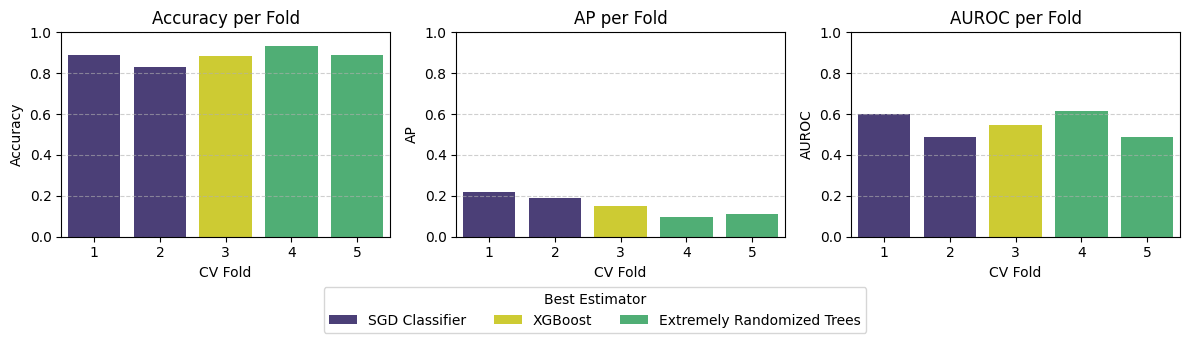

In [65]:
# 1. Your new result dictionary
CV_BestModels900 = {
    0: {'estimator': 'SGD Classifier', 'accuracy': 0.8885, 'ap': 0.2170, 'auroc': 0.6003},
    1: {'estimator': 'SGD Classifier', 'accuracy': 0.8307, 'ap': 0.1914, 'auroc': 0.4893},
    2: {'estimator': 'XGBoost', 'accuracy': 0.8839, 'ap': 0.1493, 'auroc': 0.5466},
    3: {'estimator': 'Extremely Randomized Trees', 'accuracy': 0.9306, 'ap': 0.0975, 'auroc': 0.6134},
    4: {'estimator': 'Extremely Randomized Trees', 'accuracy': 0.8882, 'ap': 0.1100, 'auroc': 0.4878}
}

data_list = []
for fold, results in CV_BestModels900.items():
    data_list.append({
        'CV Fold': fold + 1,
        'Estimator': results['estimator'],
        'Accuracy': results['accuracy'],
        'AP': results['ap'],
        'AUROC': results['auroc']
    })

Df900sec = pd.DataFrame(data_list)

metrics = ['Accuracy', 'AP', 'AUROC']
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

palette = sns.color_palette("viridis", 25)
color_map = {
    "SGD Classifier": palette[3],
    "Extremely Randomized Trees": palette[17],
    "XGBoost": palette[24]
}

for i, metric in enumerate(metrics):
    sns.barplot(data=Df900sec, x='CV Fold', y=metric, hue='Estimator', palette=color_map, ax=axes[i], dodge=False)
    axes[i].set_title(f'{metric} per Fold')
    axes[i].set_ylim(0, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    
    # Clean up individual legends
    if axes[i].get_legend():
        axes[i].get_legend().remove()

# 4. Single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Best Estimator (FLAML for 900s each CV-fold)', loc='lower center',
fig.legend(handles, labels, title='Best Estimator', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)

plt.tight_layout()
# plt.savefig('fold_performance_900.png', bbox_inches='tight', dpi=300)
plt.show()

### AutoML "classification" was run optimizing on metirc "ap" (1200 seconds)

In [11]:
# Start the total timer for the entire CV process
total_start_time = time.time()

CV_BestModels1200 = {}

for i in tqdm(range(len(CV_Folds)), desc="Outer CV folds"):
    # Record the start time of this specific fold
    fold_start_time = time.time()

    # unpack
    X_train, y_train = CV_Folds[i]["X_train"]
    X_val,   y_val   = CV_Folds[i]["X_val"]
    groups_train     = CV_Folds[i]["groups_train"]

    automl = AutoML()
    settings = {
        "time_budget": 1200,
        "task": "classification",
        "metric": "ap",
        "verbose": 1,
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
        "groups": groups_train,
    }
    
    # Run FLAML
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    # Calculate metrics (predict, proba, etc.)
    y_pred = automl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    classes_ = getattr(automl, "classes_", np.unique(y_train))
    if hasattr(automl, "predict_proba"):
        y_proba = automl.predict_proba(X_val)
        pos_label = 1 if 1 in classes_ else classes_[-1]
        pos_idx = list(classes_).index(pos_label)
        y_score = y_proba[:, pos_idx]
    else:
        pos_label = 1 if 1 in classes_ else classes_[-1]
        y_score = (y_pred == pos_label).astype(float)

    ap = average_precision_score(y_val, y_score)
    auroc = roc_auc_score(y_val, y_score)

    # Calculate fold duration
    fold_duration = time.time() - fold_start_time

    CV_BestModels1200[i] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "loss": automl.best_loss,
        "accuracy": acc,
        "ap": ap,
        "auroc": auroc,
        "duration_sec": fold_duration # Store the time taken
    }
    
    print(f"  > Fold {i} finished in {fold_duration:.2f} seconds.")

# Final report
total_duration = time.time() - total_start_time
print(f"\n--- Total Cross-Validation Time: {total_duration/60:.2f} minutes ---")

Outer CV folds:  20%|█████████████                                                    | 1/5 [20:18<1:21:15, 1218.81s/it]

  > Fold 0 finished in 1218.81 seconds.


Outer CV folds:  40%|██████████████████████████                                       | 2/5 [40:20<1:00:26, 1208.77s/it]

  > Fold 1 finished in 1201.74 seconds.


Outer CV folds:  60%|███████████████████████████████████████                          | 3/5 [1:00:20<40:09, 1204.96s/it]

  > Fold 2 finished in 1200.42 seconds.


Outer CV folds:  80%|████████████████████████████████████████████████████             | 4/5 [1:20:25<20:04, 1204.76s/it]

  > Fold 3 finished in 1204.46 seconds.


Outer CV folds: 100%|█████████████████████████████████████████████████████████████████| 5/5 [1:40:25<00:00, 1205.13s/it]

  > Fold 4 finished in 1200.18 seconds.

--- Total Cross-Validation Time: 100.43 minutes ---


In [12]:
CV_BestModels1200

{0: {'estimator': 'sgd',
  'best_config': {'penalty': 'l1',
   'alpha': 0.0007061692528832786,
   'l1_ratio': 1.3041761368178964e-05,
   'epsilon': 0.008233947053824103,
   'learning_rate': 'constant',
   'eta0': 0.0037971873674067192,
   'power_t': 0.5593566311667264,
   'average': False,
   'loss': 'modified_huber'},
  'loss': 0.822045715130848,
  'accuracy': 0.8885435168738899,
  'ap': 0.21699020398914354,
  'auroc': 0.5985951247483828,
  'duration_sec': 1218.8101434707642},
 1: {'estimator': 'sgd',
  'best_config': {'penalty': 'l2',
   'alpha': 0.012184107095959611,
   'l1_ratio': 0.009855315473540297,
   'epsilon': 0.1,
   'learning_rate': 'constant',
   'eta0': 0.07638375760768197,
   'power_t': 0.4469906416446031,
   'average': False,
   'loss': 'modified_huber'},
  'loss': 0.7720654643916189,
  'accuracy': 0.8307210031347962,
  'ap': 0.24336263444321624,
  'auroc': 0.6324248777078966,
  'duration_sec': 1201.7449970245361},
 2: {'estimator': 'extra_tree',
  'best_config': {'n_es

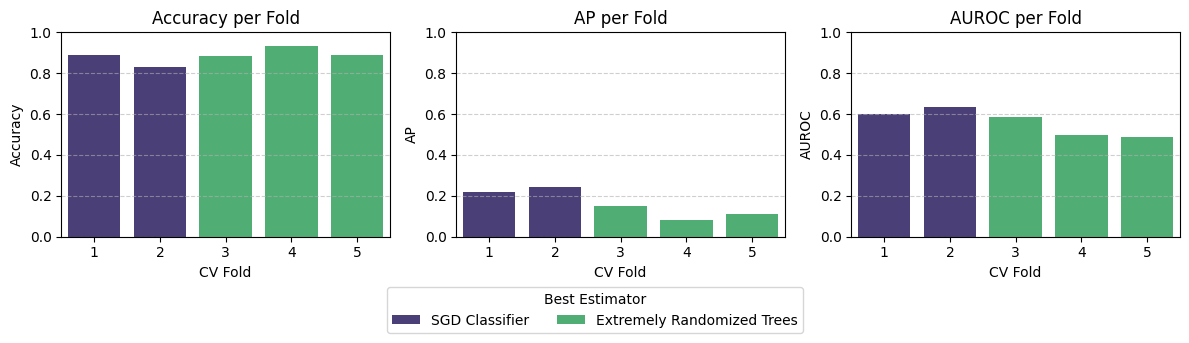

In [70]:
# 1. Your 1200-second result dictionary (Updated from your provided raw data)
CV_BestModels1200 = {
    0: {'estimator': 'SGD Classifier', 'accuracy': 0.8885, 'ap': 0.2170, 'auroc': 0.5986},
    1: {'estimator': 'SGD Classifier', 'accuracy': 0.8307, 'ap': 0.2434, 'auroc': 0.6324},
    2: {'estimator': 'Extremely Randomized Trees', 'accuracy': 0.8839, 'ap': 0.1491, 'auroc': 0.5849},
    3: {'estimator': 'Extremely Randomized Trees', 'accuracy': 0.9306, 'ap': 0.0837, 'auroc': 0.4960},
    4: {'estimator': 'Extremely Randomized Trees', 'accuracy': 0.8882, 'ap': 0.1100, 'auroc': 0.4878}
}

# 2. Convert dictionary to DataFrame
data_list = []
for fold, results in CV_BestModels1200.items():
    data_list.append({
        'CV Fold': fold + 1,
        'Estimator': results['estimator'], 
        'Accuracy': results['accuracy'],
        'AP': results['ap'],
        'AUROC': results['auroc']
    })

Df1200sec = pd.DataFrame(data_list)

# 3. Setup for subplots
metrics = ['Accuracy', 'AP', 'AUROC']
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

palette = sns.color_palette("viridis", 25)
color_map = {
    "SGD Classifier": palette[3],
    "Extremely Randomized Trees": palette[17],
    "XGBoost": palette[24]
}
for i, metric in enumerate(metrics):
    sns.barplot(
        data=Df1200sec, x='CV Fold', y=metric, hue='Estimator', 
        palette=color_map, ax=axes[i], dodge=False
    )
    axes[i].set_title(f'{metric} per Fold')
    axes[i].set_ylim(0, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    
    if axes[i].get_legend():
        axes[i].get_legend().remove()

# 4. Single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Best Estimator', loc='lower center', 
           bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

plt.tight_layout()
plt.show()

### AutoML "classification" was run optimizing on metirc "auroc"

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning,
    module="sklearn",
)

CV_BestModels2 = {}

for i in tqdm(range(len(CV_Folds)), desc="Outer CV folds"):
    # unpack
    X_train, y_train = CV_Folds[i]["X_train"]
    X_val,   y_val   = CV_Folds[i]["X_val"]
    groups_train     = CV_Folds[i]["groups_train"]

    automl = AutoML()
    settings = {
        "time_budget": 500,
        "task": "classification",
        "metric": "roc_auc", # 'roc_auc': minimize 1 - roc_auc_score. Default metric for binary classification.
        "verbose": 1,
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
        "groups": groups_train,
    }
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    # predicted labels -> use for accuracy
    y_pred = automl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    # probabilities -> use for AP/AUROC
    classes_ = getattr(automl, "classes_", np.unique(y_train))
    if hasattr(automl, "predict_proba"):
        y_proba = automl.predict_proba(X_val)
        # ensure we take the positive-class probability
        # prefer label 1 if present; else use the larger label
        pos_label = 1 if 1 in classes_ else classes_[-1]
        pos_idx = list(classes_).index(pos_label)
        y_score = y_proba[:, pos_idx]
    else:
        # fallback: make a pseudo-prob from labels (not ideal, but avoids crashes)
        pos_label = 1 if 1 in classes_ else classes_[-1]
        y_score = (y_pred == pos_label).astype(float)

    ap = average_precision_score(y_val, y_score)
    auroc = roc_auc_score(y_val, y_score)

    CV_BestModels2[i] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "loss": automl.best_loss,
        "accuracy": acc,
        "ap": ap,
        "auroc": auroc,
    }

In [ ]:
CV_BestModels2

In [ ]:
for i, j in CV_BestModels.items():
    print(f"Fold{i+1}, estimator: {j['estimator']}")
    print("\t", "accuracy:", round(j['accuracy'], 3))
    print("\t", "ap:", round(j['ap'], 3))
    print("\t", "auroc:", round(j['auroc'], 3))